# Topology of time series

This notebook explores how `giotto-tda` can be used to gain insights from time-varying data, using ideas from from dynamical systems and persistent homology.

If you are looking at a static version of this notebook and would like to run its contents, head over to [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/topological_timeseries.ipynb).

## Useful references

* [Topological Time Series Analysis](https://arxiv.org/abs/1812.05143) by Jose Perea.
* [Topological Methods for the Analysis of Data](https://youtu.be/DZwK2gT-d8g) by Jose Perea
* The sliding window notebooks from Chris Tralie's [TDALabs](https://github.com/ctralie/TDALabs)

## From time series to sliding window embeddings

The first step in analysing the topology of time series is to construct a so-called _**sliding window embedding**_, invented by Takens in the 1960s. A sliding window embedding can be thought of as sliding a "window" of fixed size over a signal, with each window represented as a point in a (possibly) higher-dimensional space.

More formally, given a time series $f(t)$, one can extract a _**sequence of vectors**_ of the form $f_i = [f(t_i), f(t_i + 2 \tau), \ldots, f(t_i + M \tau)] \in \mathbb{R}^{M+1}$, where $M$ is the _**embedding dimension**_ and $\tau$ is the _**time delay**_. The quantity $M\tau$ is known as the "window size" and the difference between $t_{i+1}$ and $t_i$ is called the **_stride_**. In other words, the sliding window embedding of $f$ with parameters $(M,\tau)$ is the function

$$
SW_{M,\tau} f : \mathbb{R} \to \mathbb{R}^{M+1}\,, \qquad t \to \begin{bmatrix}
           f(t) \\
           f(t + \tau) \\
           f(t + 2\tau) \\
           \vdots \\
           f(t + M\tau)
         \end{bmatrix}
$$


and the main idea we will explore in this notebook is that if $f$ has a non-trivial recurrent structure, then the image of $SW_{M,\tau}f$ will have non-trivial topology for appropriate choices of $(M, \tau)$.

## A periodic example

As a warm-up, recall that a function is periodic with period $T > 0$ if $f(t + T) = f(t)$ for all $t \in \mathbb{R}$. For example, consider the function $f(t) = \cos(5 t)$ which can be visualised as follows:

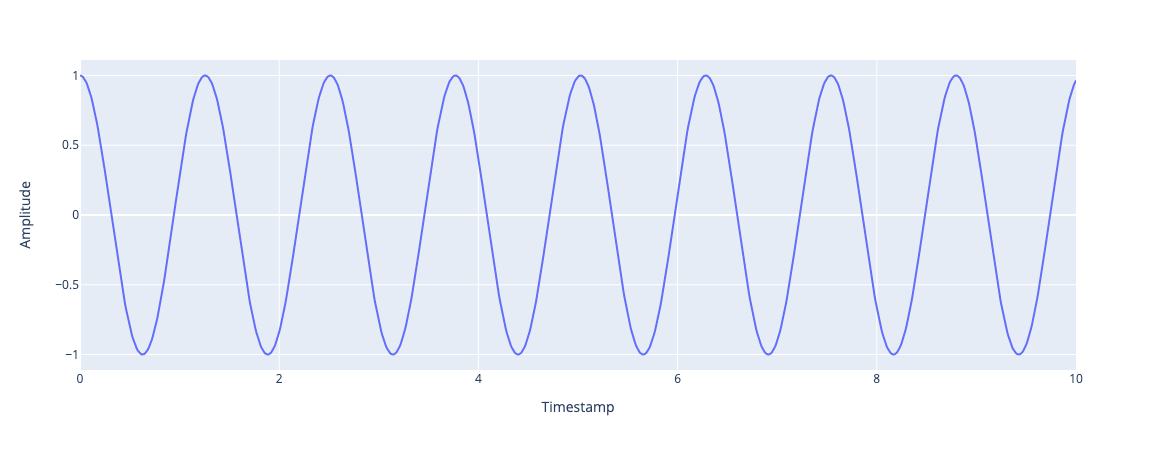

In [71]:
import numpy as np
import pandas as pd

pd.options.plotting.backend = "plotly"

x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.cos(5 * x_periodic)

ts_periodic = pd.DataFrame({"Timestamp": x_periodic, "Amplitude": y_periodic})
ts_periodic.plot(x="Timestamp", y="Amplitude")

We can show that periodicity implies circularity of the sliding window embedding. To do that we need to specify the embedding dimension $M$ and the time delay $\tau$ for the Takens embedding, which in `giotto-tda` can be achieved as follows:

In [60]:
from gtda.time_series import TakensEmbedding

embedding_dimension_periodic = 3
embedding_time_delay_periodic = 8
stride = 10

embedder_periodic = TakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

> Tip: You can use the `stride` parameter to downsample the sliding window embedding. This is handy when you want to quickly compute persistence diagrams on a dense signal.

Let's apply this embedding to our time series to get a _new_ time series:

In [78]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
y_periodic_embedded.shape

(99, 3)

We have gone from a one-dimensional series to a 3-dimensional one, so let's visualise the sliding window embedding as a point cloud:

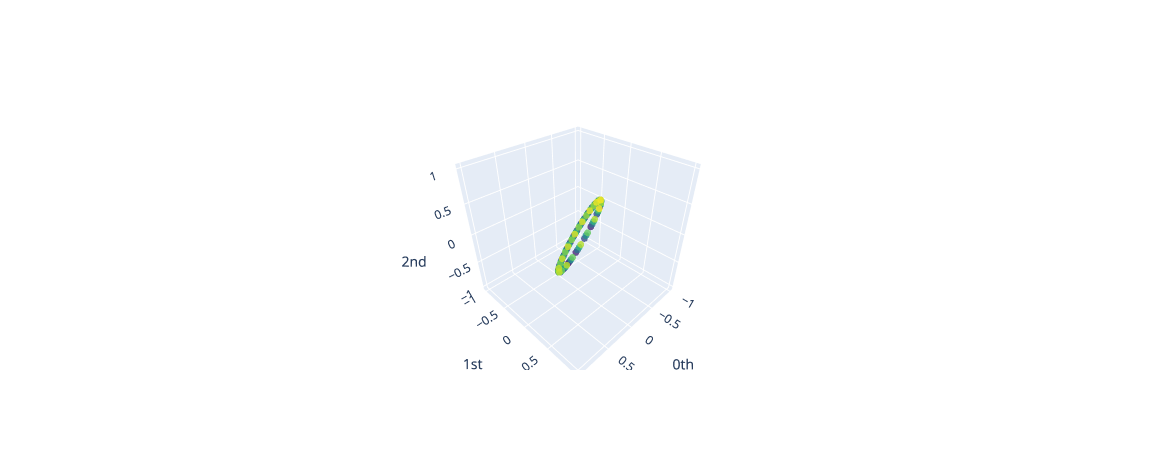

In [66]:
from gtda.plotting import plot_point_cloud

plot_point_cloud(y_periodic_embedded)

As promised, the periodicity of $f$ is reflected in the circularity of the sliding window embedding! It turns out that in general, _**periodic functions trace out ellipses**_ in $\mathbb{R}^{M+1}$. 

## A non-periodic example

Here is another type of recurrent behaviour: if we let $f(t) = \cos(t) + \cos(\pi t)$ then it follows that $f$ is not periodic since the ratio of the two frequencies is irrational, i.e. we say that $\cos(t)$ and $\cos(\pi t)$ are _incommensurate_. Nevertheless, their sum produces recurrent behaviour:

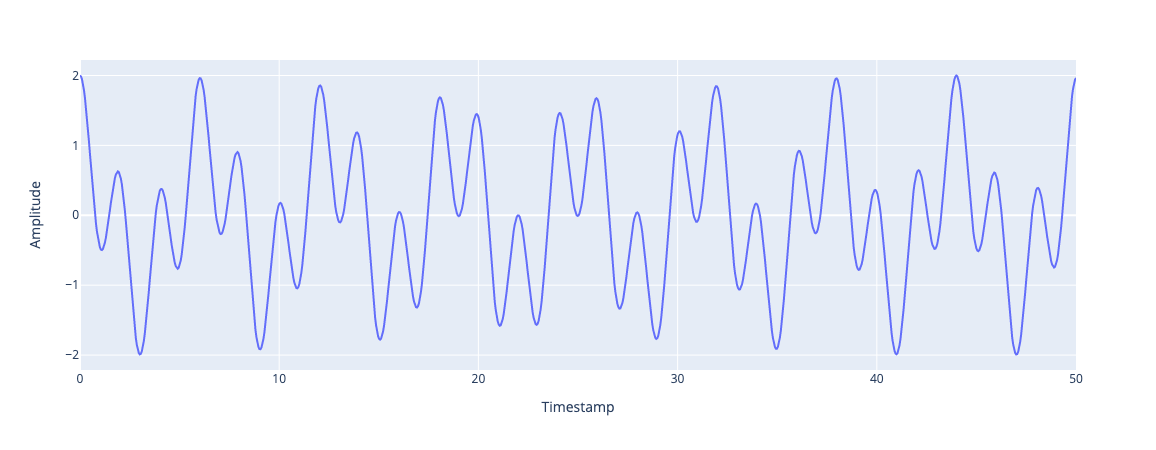

In [81]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

ts_nonperiodic = pd.DataFrame({"Timestamp": x_nonperiodic, "Amplitude": y_nonperiodic})
ts_nonperiodic.plot(x='Timestamp', y='Amplitude')

As before, let's create a sliding window embedding for this signal and visualise the resulting point cloud:

In [82]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = TakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

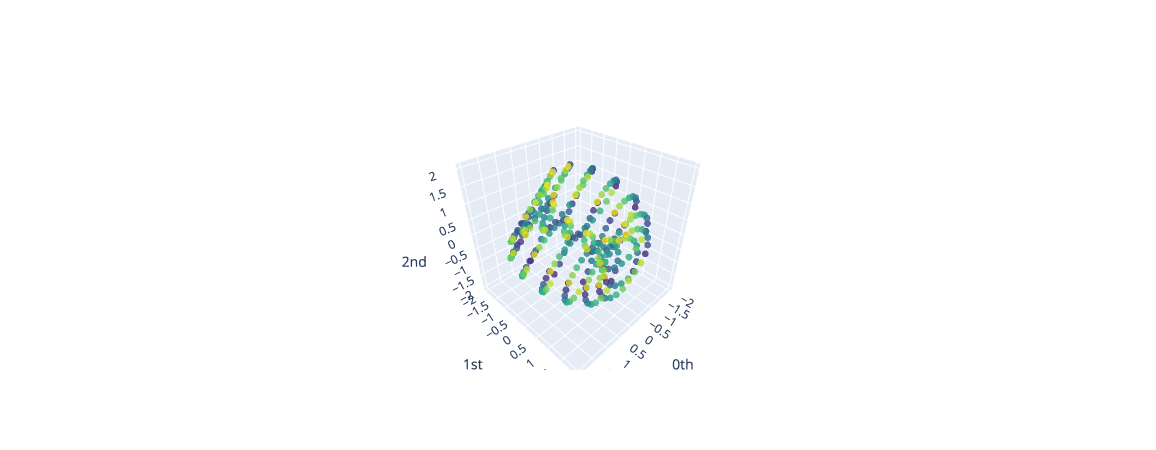

In [83]:
y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(df['Amplitude'])

plot_point_cloud(y_nonperiodic_embedded)

## From sliding window embeddings to persistence diagrams

In the examples above we saw that the resulting point clouds appear to exhibit distinct topology. We can verify this explicitly using persistent homology! First we need to reshape our point cloud arrays in a form suitable for the Vietoris-Rips construction, namely `(n_samples, n_points, n_dimensions)`:

In [84]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

The next step is to calculate the persistence diagrams associated with each point cloud. In `giotto-tda` we can do this with the Vietoris-Rips construction as follows:

Persistent diagram for periodic signal


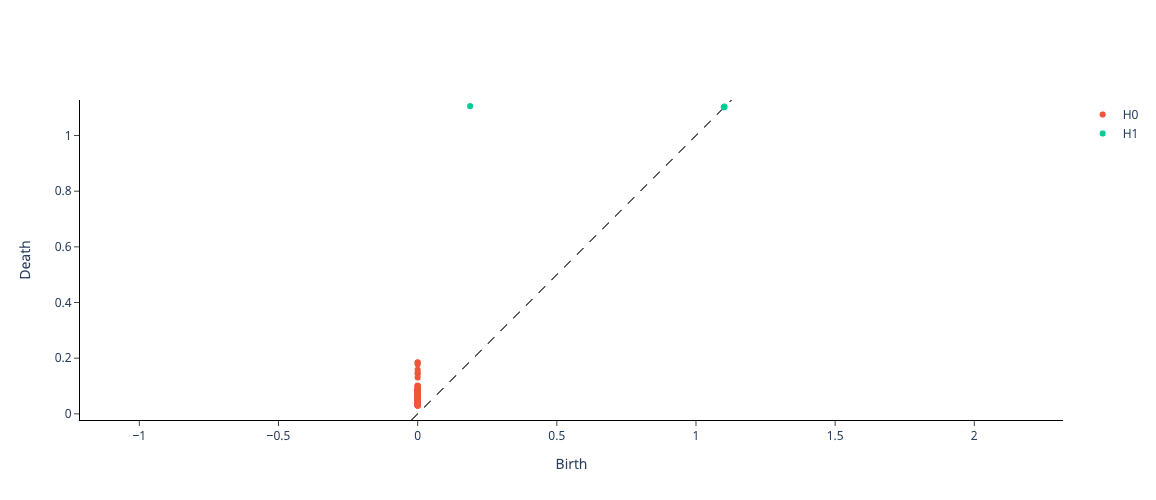

Persistent diagram for nonperiodic signal


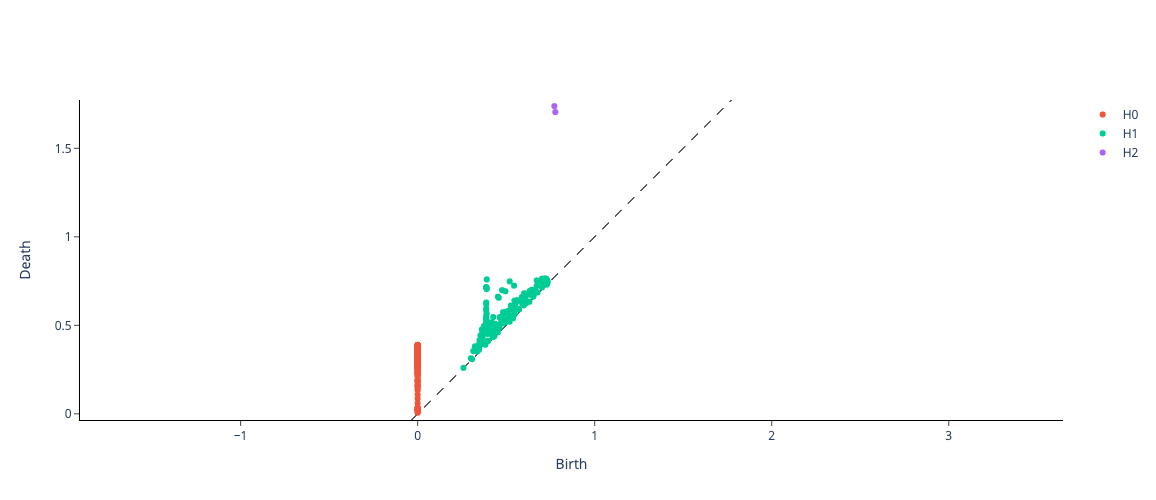

In [94]:
from gtda.homology import VietorisRipsPersistence

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
print('Persistent diagram for periodic signal')
periodic_persistence.fit_transform_plot(y_periodic_embedded);

nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
print('Persistent diagram for nonperiodic signal')
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded);

What can conclude from these diagrams? The first thing that stands out is the different types of homology dimensions that are most persistent. In the periodic case we see a single point associated with 1-dimensional persistent homology, namely a loop! On the other hand, the non-periodic signal has revealed two points associated with 2-dimensional persistent homology, namely _voids_. These clear differences in topology make the sliding window embedding technique especially powerful at classifying different time series.

## Picking the embedding dimension and time delay

In the examples above, we manually chose values for the embedding dimension $M$ and time delay $\tau$. However, it turns out there are two techniques that can be used to determine these parameters _automatically_:

* [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) to determine $\tau$
* [False nearest neighbours](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm) to determine $M$

In `giotto-tda`, these techniques are applied when we select `parameters_type="search"` in the `TakensEmbedding` transformer, e.g.

```python
embedder = TakensEmbedding(
    parameters_type="search", time_delay=time_delay, dimension=embedding_dimension,
)
```

where the values of `time_delay` and `embedding_dimension` provide _**upper bounds**_ on the search algorithm. Before applying this to our sample signals, let's have a look at how these methods actually work under the hood.

### Mutual information
To determine an optimal value for $\tau$ we first calculate the maximum $x_\mathrm{max}$ and minimum $x_\mathrm{min}$ values of the time series, and divide the interval $[x_\mathrm{min}, x_\mathrm{max}]$ into a large number of bins. We let $p_k$ be the probability that an element of the time series is in the $k$th bin and let $p_{j,k}$ be the probability that $x_i$ is in the $j$th bin while $x_{i+\tau}$ is in the $k$th bin. Then the mutual information is defined as:

$$ I(\tau) = - \sum_{j=1}^{n_\mathrm{bins}} \sum_{k=1}^{n_\mathrm{bins}} p_{j,k}(\tau) \log \frac{p_{j,k}(\tau)}{p_j p_k} $$

The first minimum of $I(\tau)$ gives the optimal delay since there we get the most information by adding $x_{i+\tau}$.

### False nearest neighbours

The false nearest neighbours algorithm is based on the assumption that "unfolding" or embedding a deterministic system into successively higher dimensions is smooth. In other words, points which are close in one embedding dimension should be close in a higher one. More formally, if we have a point $p_i$ and neighbour $p_j$, we check if the normalised distance $R_i$ for the next dimension is greater than some threshold $R_\mathrm{th}$:

$$ R_i = \frac{\mid x_{i+m\tau} - x_{j+m\tau} \mid}{\lVert p_i - p_j \rVert} > R_\mathrm{th}$$

If $R_i > R_\mathrm{th}$ then we have a "false nearest neighbour" and the optimal embedding dimension is obtained by minimising the total number of such neighbours.

### Running the search algorithm

Let's now apply these ideas to our original signals to see what the algorithm determines as optimal choices for $M$ and $\tau$. We will allow the search to scan up to relatively large values of $(M, \tau)$ to ensure we do not get stuck in a sub-optimal minimum.

For the periodic signal, we initialise the Takens embedding as follows:

In [109]:
max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder_periodic = TakensEmbedding(
    parameters_type="search", time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride
)

Let's create a helper function to view the optimal values found during the search:

In [112]:
def fit_embedder(embedder, y, verbose=True):
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

In [113]:
y_periodic_embedded = fit_embedder(embedder_periodic, y_periodic)

Shape of embedded time series: (171, 6)
Optimal embedding dimension is 6 and time delay is 29


Although the resulting embedding is in a high dimensional space, we can apply dimensionality reduction techniques like [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project down to 3-dimensions for visualisation:

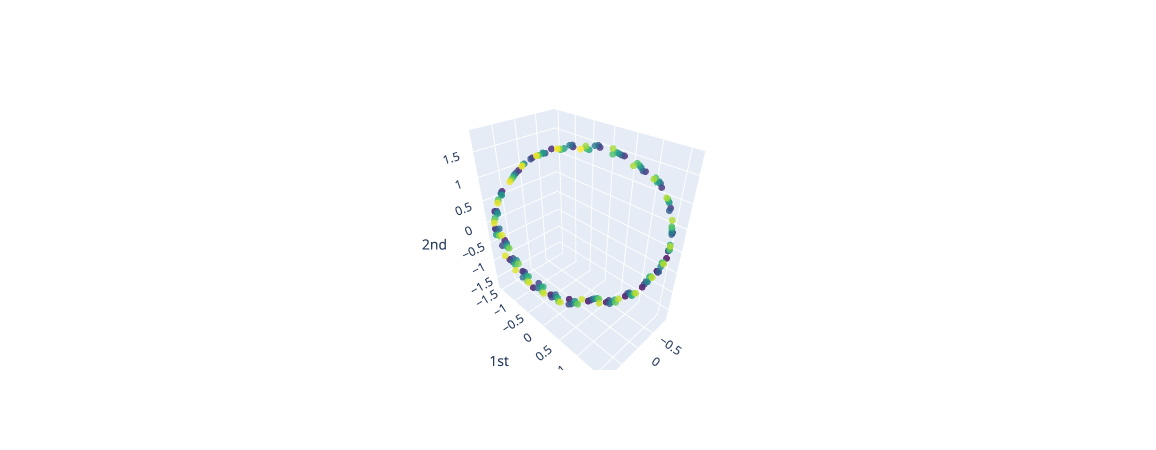

In [105]:
from sklearn.manifold import MDS

mds = MDS(n_components=3)
y_periodic_embedded_mds = mds.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_mds)

Now for the non-periodic case we have:

In [114]:
embedder_nonperiodic = TakensEmbedding(
    parameters_type="search", n_jobs=2, time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride,
)

y_nonperiodic_embedded = fit_embedder(embedder_nonperiodic, y_nonperiodic)

Shape of embedded time series: (186, 6)
Optimal embedding dimension is 6 and time delay is 14


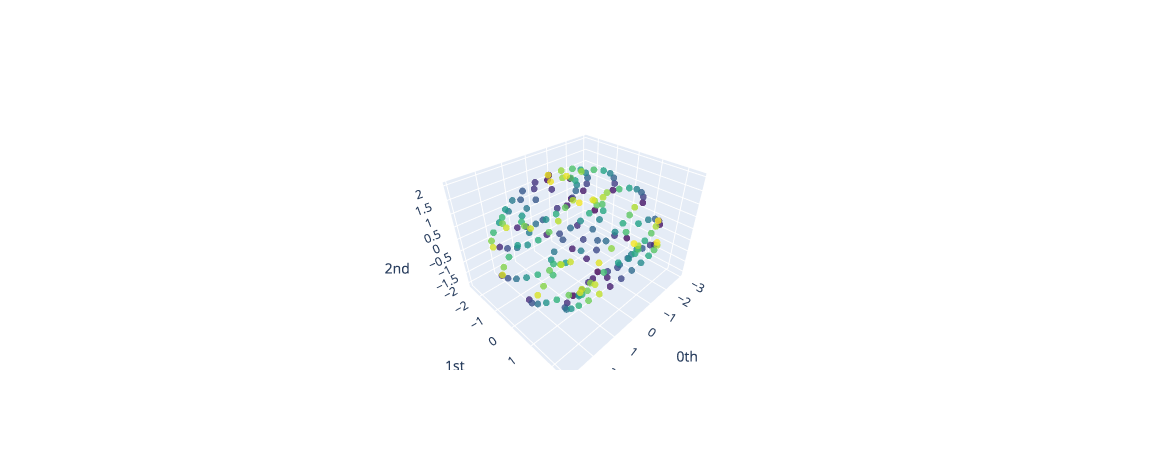

In [108]:
mds = MDS(n_components=3)
y_nonperiodic_embedded_mds = mds.fit_transform(y_nonperiodic_embedded)
plot_point_cloud(y_nonperiodic_embedded_mds)

So we have embedding point clouds whose geometry looks clearly distinct; how about the persistence diagrams? As we did earlier, we first need to reshape our arrays into the form `(n_samples, n_points, n_dimensions)`:

In [115]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

The next step is to calculate the persistence diagrams associated with each point cloud:

Persistent diagram for periodic signal


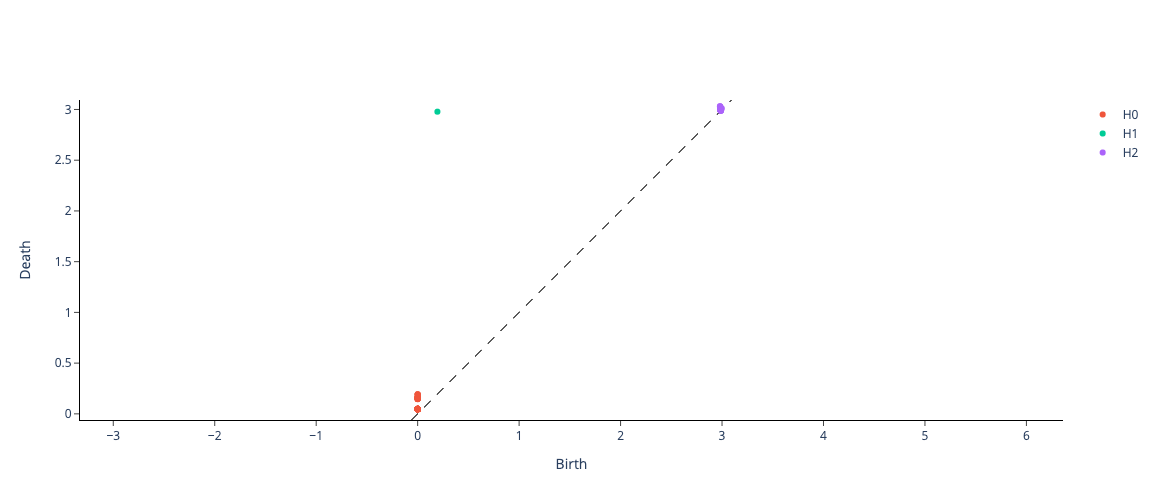

Persistent diagram for nonperiodic signal


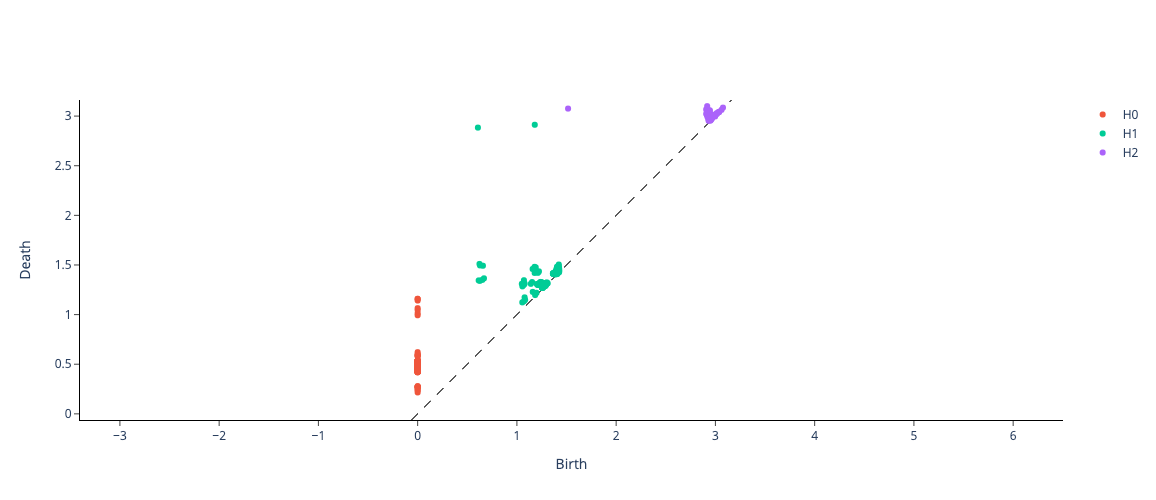

In [118]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
print('Persistent diagram for periodic signal')
periodic_persistence.fit_transform_plot(y_periodic_embedded);

nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
print('Persistent diagram for nonperiodic signal')
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded);

In this case the persistence diagram for the periodic signal is essentially unchanged, but the non-periodic signal now reveals two $H_1$ points and one $H_2$ one - the signature of a hypertorus! It turns out that in general, the image of $SW_{M,\tau}f$ is a hypertorus.